<a href="https://colab.research.google.com/github/yusras99/SWE-Intern-EvilGen/blob/main/Swe_Intern_EvilGen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
###### Set Up #####
# verify our folder with the data and module assets is installed
# if it is installed make sure it is the latest
!test -e SWE-Intern-EvilGen && cd SWE-Intern-EvilGen && git pull && cd ..
# if it is not installed clone it 
!test ! -e SWE-Intern-EvilGen && git clone https://github.com/yusras99/SWE-Intern-EvilGen.git
# point to the folder with the parquet file
home = "SWE-Intern-EvilGen/Software Engineer Assessment/data" 
import sys
sys.path.append(home)      # add home folder to module search path

Cloning into 'SWE-Intern-EvilGen'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 21 (delta 2), reused 2 (delta 0), pack-reused 0
Unpacking objects: 100% (21/21), 2.03 MiB | 5.88 MiB/s, done.


In [2]:
!pip install pyarrow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Class Implementation

In [3]:
#numpy makes the computation of large arrays like the ones in this data faster
#because it is implemented in c and optimized for performance.
#it performs computations in vectorized manner(paralell processing)and hence making computations fast
import numpy as np
#imported to read Parquet File efficiently
import pyarrow.parquet as pq
#imported to parse the json column
import json
#imported for storing data in dataframe and performing functions
import pandas as pd

#This function prevents computations every time a row is checked, and does it once only hence increasing efficiency
def computeMinMax(boundaryCoords):
    #[:,0] -> Gives first column of all rows, and [:,1]-> Gives second column of all rows
    xMin = np.min(boundaryCoords[:, 0])
    xMax = np.max(boundaryCoords[:, 0])
    yMin = np.min(boundaryCoords[:, 1])
    yMax = np.max(boundaryCoords[:, 1])
    return xMin, xMax, yMin, yMax

class ProcessGameState:
  #constructor for the class
  def __init__(self, dataPath,boundaryCoords):
    self.dataPath = dataPath
    self.table = None
    #Assign all the min and max values of the boundary coordinates
    self.xMin, self.xMax, self.yMin, self.yMax = computeMinMax(boundaryCoords)
    self.rows = None

  def dataIngestion(self):
    #use fast parquet to read the parquet file and store it in the pandas dataframe
    filePath = home+self.dataPath
    self.table = pq.read_table(filePath).to_pandas()
    self.rows = self.table.iloc[0:]

  def isInBounds(self,rows):
    #Test whether all array elements along x axis and y axis are within bounds are not, if they are it returns True else False. 
    #The efficiency of this function is O(1) for each row.
    xInBounds = (rows['x'] >= self.xMin) & (rows['x'] <= self.xMax)
    yInBounds = (rows['y'] >= self.yMin) & (rows['y'] <= self.yMax)
    return xInBounds & yInBounds



  def weaponClassExtraction(self, row):
    weaponClassArr = []
    inventoryJsonCol = row["inventory"]
    if inventoryJsonCol is not None: #inventoryJsonCol is the pandas dataframe column
          for JsonList in inventoryJsonCol: #for the lists in the column
            if JsonList is not None: 
              try: #try block to handle invalid data
                if not isinstance(JsonList, dict): #if it is not a dictionary but a numpy array of dictionaries do this 
                  if isinstance(JsonList, str): #if it is a string convert it deserialize it into a python object
                    filteredJsonList = json.loads(JsonList)
                  else:
                    filteredJsonList = JsonList
                  for JsonObject in filteredJsonList: #for every object in the list of python objects, find the value for the key weapon_class
                    if JsonObject is not None and 'weapon_class' in JsonObject:    
                        weaponClassArr.append(JsonObject['weapon_class'])
                else:
                  if JsonList is not None and 'weapon_class' in JsonList:
                    weaponClassArr.append(JsonList['weapon_class'])
              except json.JSONDecodeError:
                  print("Invalid data")
    #empty array will be returned if inventoryJsonCol is null or if weapon_class doesn't exist
    return weaponClassArr

# Class Execution

In [4]:
# boundaryCoords saved as a numpy array
boundaryCoords = np.array([[-1735, 250],
                            [-2024, 398],
                            [-2806, 742],
                            [-2472, 1233],
                            [-1565, 580]])
# Create an instance of the ProcessGameState class
currentGameState = ProcessGameState("/game_state_frame_data.parquet", boundaryCoords)

## Question 1

a. Handle  file  ingestion  and  ETL  (if  deemed  necessary)

In [5]:
# Ingest the Parquet file to perform functions on it
currentGameState.dataIngestion()

b. Return  whether  or  not  each  row  falls  within  a  provided  boundary
>i. Be  as  efficient  as  possible  (minimize  runtime)


>ii. Reduce  dependencies  outside  of  standard  Python  libraries  unless 
you  can  prove  significant  improvements

In [6]:
# Check if all rows are in bounds, and print the result
allRowsInBounds = currentGameState.isInBounds(currentGameState.rows)
print("All rows in bounds: {}".format(allRowsInBounds))

All rows in bounds: 0         False
1         False
2         False
3         False
4         False
          ...  
221325    False
221326    False
221327    False
221328    False
221329    False
Length: 221330, dtype: bool


c. Extract  the  weapon  classes  from  the inventory  json  column

In [7]:
# Extract weapon classes
print("Row is \n",currentGameState.rows[0:1])
weaponClasses = currentGameState.weaponClassExtraction(currentGameState.rows[0:1])
print("The weapon classes extracted from this row are: ",weaponClasses)

Row is 
    round_num  tick side   team   hp  armor  is_alive     x     y    z  ...  \
0          1  2511    T  Team1  100    100      True -1310 -3333  294  ...   

  equipment_value_freezetime_end  area_name  seconds clock_time  t_alive  \
0                            900     TSpawn        0      01:55        5   

  ct_alive  bomb_planted     map_name  utility_used   player  
0        5         False  de_overpass           0.0  Player0  

[1 rows x 22 columns]
The weapon classes extracted from this row are:  ['Pistols', 'Grenade']


## Question 2

a. Is  entering  via  the  light  blue  boundary  a common  strategy  used  by Team2  on  T (terrorist) side?

In [8]:
def teamStrategy(data,teamNum,sideType):
      # Filter the table with only rows which have teamNum and sideType as specified in the parameters
      filteredRows = data.table[(data.table["team"]==teamNum) & (data.table["side"]== sideType)]
      # count the number of occurences of how many players of teamNum , from sideType are entering from the light blue boundary
      isInBoundsBoolTable = data.isInBounds(filteredRows)
      inBoundsBoolArr = isInBoundsBoolTable.value_counts() 
      # if there are more rows in bounds than it is a common strategy
      isCommonStrategy = inBoundsBoolArr [True] > inBoundsBoolArr[False]
      print("Rows in bounds: ",inBoundsBoolArr[True])
      print("Rows not in bounds: ",inBoundsBoolArr[False])
      print("Is being in bounds a common strategy? - ",isCommonStrategy)
      return isCommonStrategy
isCommonStrategy = teamStrategy(currentGameState,"Team2","T")

Rows in bounds:  2974
Rows not in bounds:  51936
Is being in bounds a common strategy? -  False


Ans - No its not a common strategy for Team 2 players to enter from light blue boundary on terrorist side, as they used this strategy only 2974 times and didn't use it for 51936 times. 

b. What  is  the  average  timer  that  Team2  on  T  (terrorist)  side  enters 
“BombsiteB”  with  least  2  rifles  or  SMGs?

In [9]:
def avgTimer(data, teamNum, sideType, areaName,weaponClassNames,weaponCount):
    # Filter the table with only rows which have teamNum and sideType as specified in the parameters
    filteredRows = data.table[(data.table["team"]==teamNum) 
                              & (data.table["side"]== sideType)
                              & (data.table["area_name"]== areaName)
                              ]
    elapsedTimeArr=[]
    found=False
    #Extract the weapon classes of the filtered Table
    for _, row in filteredRows.iterrows():
        weaponClassFiltered = data.weaponClassExtraction(row)
        if len(weaponClassFiltered) >= weaponCount:
          #the weapons extracted from the row should have at least weaponCount number of weapons from weaponClassNames array
          #either all weapons together from the weaponClassNames should be equal to weaponCount, or any one should be equal to weaponCount
          foundCount = sum(weapon in weaponClassFiltered for weapon in weaponClassNames) 
          if foundCount >= weaponCount: 
              elapsedTimeArr.append(row["seconds"])
        print("The weapons extracted from the rows are: ",weaponClassFiltered)
    # calculate average time of all of these rows, only if anything was found
    if len(elapsedTimeArr)>0:
      avgTime = sum(elapsedTimeArr) / len(elapsedTimeArr)
      print("The times in seconds at which players who fulfill the condition, enter in the area are:",elapsedTimeArr)
      print("The average times at which players who fulfill the condition, enter in the area is:",avgTime)
    else:
      print("Condition not fulfilled, no rows found with the specified condition")
weaponClassNames = ["Rifle","SMG"]
avgTimer(currentGameState,"Team2","T", "BombsiteB",weaponClassNames,2)

The weapons extracted from the rows are:  ['Pistols']
The weapons extracted from the rows are:  ['Pistols']
The weapons extracted from the rows are:  ['Pistols']
The weapons extracted from the rows are:  ['Pistols']
The weapons extracted from the rows are:  ['Pistols']
The weapons extracted from the rows are:  ['Pistols']
The weapons extracted from the rows are:  ['Pistols']
The weapons extracted from the rows are:  ['Pistols']
The weapons extracted from the rows are:  ['Pistols']
The weapons extracted from the rows are:  ['Pistols']
The weapons extracted from the rows are:  ['Pistols']
The weapons extracted from the rows are:  ['Pistols']
The weapons extracted from the rows are:  ['Pistols']
The weapons extracted from the rows are:  ['Pistols']
The weapons extracted from the rows are:  ['Pistols']
The weapons extracted from the rows are:  ['Pistols']
The weapons extracted from the rows are:  ['Pistols']
The weapons extracted from the rows are:  ['Pistols']
The weapons extracted from t

c. Now  that  we’ve  gathered  data  on  Team2  T  side,  let's  examine  their  CT (counter-terrorist)  Side.  Using  the  same  data  set,  tell  our  coaching staff  where  you  suspect  them  to  be  waiting  inside  “BombsiteB”
>i. Hint:  Try  a  heatmap

67137    -1142
67138    -1111
67139    -1081
67140    -1050
67141    -1027
          ... 
208375    -939
208376    -922
208377    -908
208378    -891
208379    -877
Name: x, Length: 6030, dtype: int64 67137     311
67138     310
67139     308
67140     307
67141     295
         ... 
208375   -193
208376   -217
208377   -241
208378   -263
208379   -286
Name: y, Length: 6030, dtype: int64


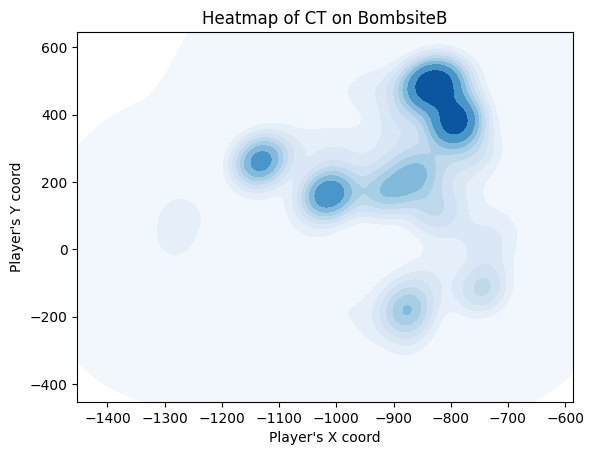

77956     -724
77957     -736
77958     -746
77959     -756
77960     -769
          ... 
220038   -1131
220039   -1143
220045   -1142
220046   -1137
220047   -1132
Name: x, Length: 3835, dtype: int64 77956      -3
77957      25
77958      53
77959      82
77960     109
         ... 
220038    320
220039    321
220045    331
220046    352
220047    375
Name: y, Length: 3835, dtype: int64


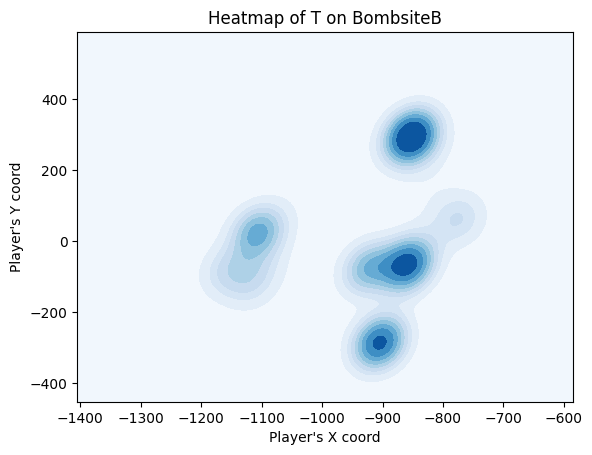

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

def waitingLocationCT(data, teamNum, sideType, areaName):
    # Filter the table with only rows which have teamNum and sideType as specified in the parameters
    filteredRows = data.table[(data.table["team"]==teamNum) 
                              & (data.table["side"]== sideType)
                              & (data.table["area_name"]== areaName)
                              ]
    #get the x & y coordinates of all of these filtered rows
    xCoordArr = filteredRows["x"]
    yCoordArr = filteredRows["y"]
    print(xCoordArr,yCoordArr)

    # plot the heatmap based on the x & y coord. 
    sns.kdeplot(data=data, x = xCoordArr, y = yCoordArr, cmap='Blues', fill=True, thresh=False)
    
    plt.xlabel("Player's X coord")
    plt.ylabel("Player's Y coord")
    plt.title('Heatmap of '+sideType+' on '+areaName)
    plt.show()
waitingLocationCT(currentGameState,"Team2","CT", "BombsiteB")
waitingLocationCT(currentGameState,"Team2","T", "BombsiteB")

Ans.  According to the heatmap, the players on counter terorrist side on bombsiteB are concentrated at -850 to -750 on x axis, and 300-500 on y axis. There is also a slight low percentage of players -1050 to -1150 x axis and 100 to 300 on y axis. The cooler tones shows low frequency and hotter blue shows higher frequency. I also plotted heatmap for T side players to show that the players on CT side have a good strategy to spread their players around the top hot area of T side. However, CT side should have more players waiting around the -900 to -500 coordinate too. 

## Question 3

3.  (No  Coding)  Most  of  the  time,  our  stakeholders  (in  this  case,  the  CS:GO 
coaching  staff)  aren’t  tech-savvy  enough  to  run  code  themselves.  Propose  a 
solution  to  your  product  manager  that:
 >a.  could  allow  our  coaching  staff  to  request  or  acquire  the  output  themselves
 
 >b.  takes  less  than  1  weeks  worth  of  work  to  implement





>Ans. For this I believe, a user-friendly web-based interface can be implemented that will allow the CS:GO coaching staff to interact with the data and obtain the desired output without requiring technical expertise. This interface will provide a simple and intuitive way for the coaching staff to input their requests and view the results.

>The interface will use natural language processing (NLP) techniques to understand the commands and queries from the coaching staff. The NLP model can quickly parse and interpret the user's input, extracting the relevant information and identifying the specific analysis or insights they are seeking. Based on the user's requests, the processor will execute the necessary code with the corresponding parameters and deliver the solution.

>The NLP is great to use for this task because they understand the context behind everything the user says. The NLP model will effectively interpret the provided data, enabling the backend code to run seamlessly, similar to our approach in previous questions. The backend developers can create different functions that cater to various user scenarios as to what the user can ask relating to the data. These functions can provide analysis and visualization functionalities. If in case any function doesn't exist for a user prompt, the SWE can be prompted about that and they can implement the function.

>Drawing from my past experience working with NLP and utilizing it for English language parsing, I am confident that we can develop a basic NLP system within a week. We can leverage pre-trained NLP models available in libraries, rather than starting from scratch. This approach allows us to expedite the development process while ensuring the accuracy and reliability of the NLP system.

>In conclusion, this solution will empower the coaching staff by granting them self-service access to the data analysis they need, harnessing the potential of NLP. It promotes efficient collaboration, eliminates dependencies on technical personnel, and enables timely decision-making based on valuable insights from the data. 


# Debugging Purpose Code

In [ ]:
#Code for Testing purposes

filePath = home+"/game_state_frame_data.parquet"
print(filePath)
tableTest = pq.read_table(filePath).to_pandas()
print(tableTest.columns)
column_data = tableTest["inventory"]
column_data = tableTest["inventory"]
sample_data = column_data[:5]  # Retrieve the first 5 items as a sample
print(sample_data)

SWE-Intern-EvilGen/Software Engineer Assessment/data/game_state_frame_data.parquet
Index(['round_num', 'tick', 'side', 'team', 'hp', 'armor', 'is_alive', 'x',
       'y', 'z', 'inventory', 'total_utility',
       'equipment_value_freezetime_end', 'area_name', 'seconds', 'clock_time',
       't_alive', 'ct_alive', 'bomb_planted', 'map_name', 'utility_used',
       'player'],
      dtype='object')
0    [{'ammo_in_magazine': 20, 'ammo_in_reserve': 1...
1    [{'ammo_in_magazine': 20, 'ammo_in_reserve': 1...
2    [{'ammo_in_magazine': 20, 'ammo_in_reserve': 1...
3    [{'ammo_in_magazine': 20, 'ammo_in_reserve': 1...
4    [{'ammo_in_magazine': 20, 'ammo_in_reserve': 1...
Name: inventory, dtype: object
